# Region-based object detection

The first approach to object detection was pre-selecting certain parts of an image (regions), putting them through algorithms (e.g., SVM, CNN). From that point, we have a classical image classification problem. As you can imagine, this approach is limiting, but it showed results.

We will cover different types of Region-based algorithms in the next couple of lessons and the ways researchers went from the worst approach (covered in this notebook) to something pretty sophisticated, Faster R-CNN.

![](https://www.researchgate.net/profile/Sitaram-Bhagavathy/publication/3204290/figure/fig9/AS:669072500981770@1536530723375/Region-based-sampling-of-observation-sequences-for-object-detection-The-test-image-is.png)
<center>Image taken from <a href="https://www.researchgate.net/figure/Region-based-sampling-of-observation-sequences-for-object-detection-The-test-image-is_fig9_3204290">here</a></center>


Over the years, the main improvements from the sliding window approach (covered in this notebook) to the end-to-end system are in selecting regions for images.

One of the best ways to learn these techniques was by building one step at a time. Having that in mind, the goal of this notebook is to demonstrate the old approach. Your goal here is to run through these code blocks and build an intuition behind the region-based approach.

NOTE: Some code blocks can take hours or even days to execute (sliding window dataset example)! I will write the notice before those cells, but just keep that in mind.

### Steps:
1. Import dependencies 
2. Download the dataset
3. Define Data Loader function
4. Sliding window data generator
5. Creating and training a network
6. Predicting over image patches

### Topics covered and learning objectives
- Sliding window technique
- Brute force approach to object detection
- Prediction over patches of images

### Time estimates:
- Reading/Watching materials: ~20min
- Exercises: /
<br><br>
- **Total**: ~20min

**NOTE: This time does not include the execution and code reading time!**

## Importing dependencies

In [1]:
from pathlib import PurePath, Path
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAvgPool2D

## Download the dataset

The dataset is an official part of the Kaggle's Data Science Bowl 2018 competition. To download this dataset, you'll need to be logged in using your Kaggle account and accept the competition rules! Link to the competition and data is [here](https://www.kaggle.com/aceofspades914/cgi-planes-in-satellite-imagery-w-bboxes)

Download it from the *[Data](https://www.kaggle.com/aceofspades914/cgi-planes-in-satellite-imagery-w-bboxes/data)* page by clicking onto **Download all**

![](images/download-bowl.png)

NOTE: The file is pretty big, about 1.3Gb. It will take some time to download it.

In the zip file, you'll find two CSV files:
- train_labels.csv
- test_labels.csv

and 3 folders, but we will need only two of them!
- train
- test

Extract all of those files into the **data/module_2** folder inside the root directory of the repo for the following to work.

After extracting everything, this was my folder structure:

<pre>
<b>data/module_2</b>
|__ <b>train_labels.csv</b>
|__ <b>test_labels.csv</b>
|__ <b>train</b>
    |______ <b>img400.xml</b>
    |______ <b>img400.png</b>
    |______ <b>...</b>
|__ <b>test</b>
    |______ <b>img500.xml</b>
    |______ <b>img500.png</b>
    |______ <b>...</b>
</pre>

In [2]:
def IoU(regionA, regionB):
    
    #evaluate the intersection points 
    xA = np.maximum(regionA['x1'], regionB['x1'])
    yA = np.maximum(regionA['y1'], regionB['y1'])
    xB = np.minimum(regionA['x2'], regionB['x2'])
    yB = np.minimum(regionA['y2'], regionB['y2'])

    # compute the area of intersection rectangle
    interArea = np.maximum(0, xB - xA + 1) * np.maximum(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    regionAArea = (regionA['x2'] - regionA['x1'] + 1) * (regionA['y2'] - regionA['y1'] + 1)
    regionBArea = (regionB['x2'] - regionB['x1'] + 1) * (regionB['y2'] - regionB['y1'] + 1)

    #compute the union 
    unionArea = (regionAArea + regionBArea - interArea)

    # return the intersection over union value
    return interArea / unionArea

## Data Loader

Take a look at the data loader function, written to load and organize all files for the dataset. 
If you want to practice, remove the testing part of the function and write it yourself.

In [22]:
def data_loader():
    REPO_DIR = Path(os.getcwd()).parent
    
    train_labels = pd.read_csv(REPO_DIR / "data/module_2/train_labels.csv")
    test_labels = pd.read_csv(REPO_DIR / "data/module_2/test_labels.csv")
    
    train_dataset = {}
    test_dataset = {}
    
    
    for i in tqdm(range(train_labels.shape[0])):
        img_path = REPO_DIR / "data/module_2/train" / train_labels.iloc[i]['filename']
        
        if img_path.parts[-1].endswith("png") and train_labels.iloc[i]['filename'] not in train_dataset:
            obj = {}
            img = cv2.cvtColor(cv2.imread(img_path.__str__()), cv2.COLOR_BGR2RGB)
            obj['img'] = img

            obj['objects'] = [{"x1":train_labels.iloc[i]['xmin'],
                               "x2":train_labels.iloc[i]['xmax'],
                               "y1":train_labels.iloc[i]['ymin'],
                               "y2":train_labels.iloc[i]['ymax']}]
            
            train_dataset[train_labels.iloc[i]['filename']] = obj
        else:
            train_dataset[train_labels.iloc[i]['filename']]['objects'].append({"x1":train_labels.iloc[i]['xmin'],
                               "x2":train_labels.iloc[i]['xmax'],
                               "y1":train_labels.iloc[i]['ymin'],
                               "y2":train_labels.iloc[i]['ymax']})

    for i in tqdm(range(test_labels.shape[0])):
        img_path = REPO_DIR / "data/module_2/test" / test_labels.iloc[i]['filename']
        
        if img_path.parts[-1].endswith("png") and test_labels.iloc[i]['filename'] not in test_dataset:
            obj = {}

            img = cv2.cvtColor(cv2.imread(img_path.__str__()), cv2.COLOR_BGR2RGB)
            obj['img'] = img

            obj['objects'] = [{"x1":train_labels.iloc[i]['xmin'],
                               "x2":train_labels.iloc[i]['xmax'],
                               "y1":train_labels.iloc[i]['ymin'],
                               "y2":train_labels.iloc[i]['ymax']}]
            
            test_dataset[train_labels.iloc[i]['filename']] = obj
        else:
            test_dataset[train_labels.iloc[i]['filename']]['objects'].append({"x1":train_labels.iloc[i]['xmin'],
                               "x2":train_labels.iloc[i]['xmax'],
                               "y1":train_labels.iloc[i]['ymin'],
                               "y2":train_labels.iloc[i]['ymax']})
    
    return train_dataset, test_dataset

In [ ]:
train_data, test_data = data_loader()

## Sliding window generator

The sliding window algorithm takes part of an image, runs an algorithm on top of it and moves the window to the next place, and repeats the process. Generally, there is no heuristic on how to select windows but just how large your object is, and you slide in the hope of recognizing something somewhere. 

![](https://pyimagesearch.com/wp-content/uploads/2014/10/sliding_window_example.gif)

Here is an excellent tutorial on how and where to apply this algorithm: https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/

Optional resource: https://www.coursera.org/lecture/deep-learning-in-computer-vision/sliding-windows-UlbVI

NOTE: Running the cell below will take 30min to 1h. We only recommend looking through this code for now. But if you have time to spare, go for it :)

In [4]:
def sliding_window_generator(img_obj,
                             img_size=(224, 224), 
                             window_size=(10, 10), 
                             step=10,
                             num_of_samples=5):
    
    training_images = []
    training_labels = []
    
    img = img_obj['img']
    pos_counter = 0
    neg_counter = 0
    
    # slide a window across the image
    for y in range(0, img.shape[0], step):
        for x in range(0, img.shape[1], step):
            # yield the current window
            sub_img = img[y:y + window_size[1], x:x + window_size[0]]
            
            for obj in img_obj['objects']:

                iou = IoU(obj, {"x1":x,"x2":x+window_size[0],"y1":y,"y2":y+window_size[1]})
                
                # Generating positive samples
                if iou > 0.7:
                    if pos_counter < 1:
                        proposal = cv2.resize(sub_img, img_size, interpolation = cv2.INTER_AREA)
                        training_images.append(proposal)
                        training_labels.append(1)
                        pos_counter += 1

                # Generating negative samples
                if iou < 0.3:
                    if neg_counter < num_of_samples:
                        proposal = cv2.resize(sub_img, img_size, interpolation = cv2.INTER_AREA)
                        training_images.append(proposal)
                        training_labels.append(0)
                        neg_counter += 1
                    
    return np.array(training_images), np.array(training_labels)

In [11]:
training_images = []
training_labels = []

for key in tqdm(train_data.keys()):
    obj = train_data[key]
    imgs, labels = sliding_window_generator(obj, window_size=(5, 5), step=5)
    training_images.append(imgs)
    training_labels.append(labels)

In [12]:
X = np.vstack(training_images)
y = np.hstack(training_labels)

In [13]:
X.shape

(2000, 224, 224, 3)

### Create training and test sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Use pre-trained VGG network as a base model, and freeze it

In [15]:
base_model = VGG16(weights='imagenet', include_top=False)

In [16]:
base_model.trainable = False

### Create a custom top that is optimized for binary classification

In [17]:
flattened_features = GlobalAvgPool2D()(base_model.output)
predictions = Dense(1, activation="sigmoid")(flattened_features)
model = Model(inputs=base_model.inputs, outputs=predictions)

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [19]:
model.fit(X_train, y_train, batch_size=32, epochs= 10, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
47/47 [==============================] - 11s 235ms/step - loss: 0.0450 - acc: 0.9980 - val_loss: 0.0131 - val_acc: 1.0000
Epoch 2/10
47/47 [==============================] - 8s 173ms/step - loss: 0.0091 - acc: 1.0000 - val_loss: 0.0069 - val_acc: 1.0000
Epoch 3/10
47/47 [==============================] - 8s 173ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 4/10
47/47 [==============================] - 8s 176ms/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 5/10
47/47 [==============================] - 8s 177ms/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 6/10
47/47 [==============================] - 8s 176ms/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 7/10
47/47 [==============================] - 8s 176ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 8/10
47/47 [==============================] - 8s 174ms/step - loss: 0

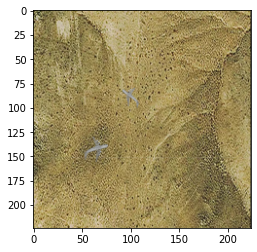

In [28]:
plt.imshow(X_test[1])

### Prediction time

Predicting with the trained model is, really, we take a sliding window and make predictions for each slice. Keep only image slices that have confidence over 70%  (0.7)

NOTE: 70% is randomly selected. You can experiment and set it higher if your model gets perfect and classifying objects

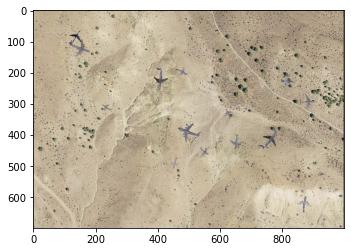

In [36]:
window_size=(10, 10)
step=10
random_img = test_data['img15.png']['img']

for y in range(0, random_img.shape[0], step):
    for x in range(0, random_img.shape[1], step):
        # yield the current window
        sub_img = random_img[y:y + window_size[1], x:x + window_size[0]]

        proposal = cv2.resize(sub_img, (224, 224), interpolation = cv2.INTER_AREA)

        img = np.expand_dims(proposal, axis=0)
        out= model.predict(img)
        if out[0][0] > 0.70:
            print(out[0][0])
            cv2.rectangle(random_img, (x, y), (x+window_size[1], y+window_size[0]), (0, 255, 0), 1, cv2.LINE_AA)

plt.figure()
plt.imshow(random_img)    

Ugh! We survived! You've probably noticed a lot of ways to improve this architecture. 

The first thing that we need to do is to change the way we get ROIs. That's precisely what we are going to next! 

Let's move to the next notebook **Selective Search**.